## Anova and Correlation

### Imports

In [195]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

### Read Data

In [196]:
INPUT_FILE = '../../data/processed/processed_data.csv'

df = pd.read_parquet(INPUT_FILE)

### Prepare the data

In [197]:
target_col = 'copiesSold'

X = df.drop(columns=[target_col, 'appid'])
y = df[target_col]

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

### Correlation with Numerical Features

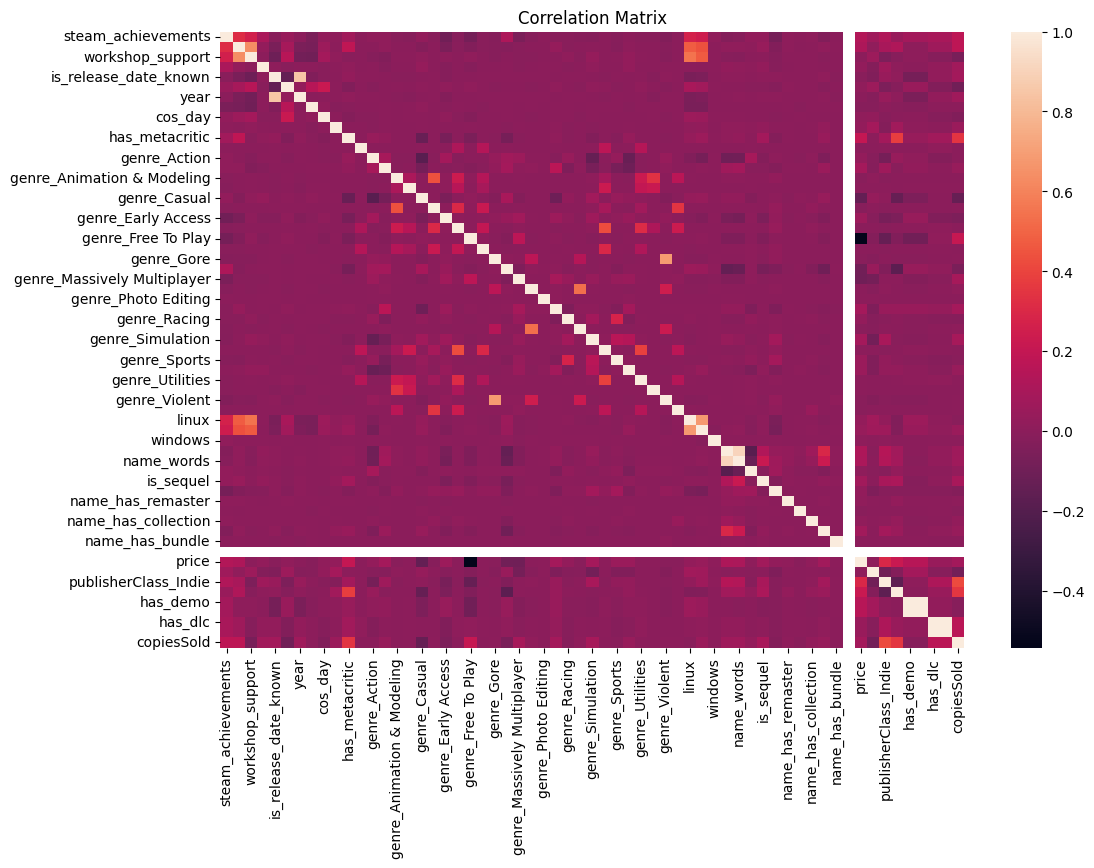

,index,feature,correlation


In [ ]:
numeric_corr = df[numerical_cols.tolist() + [target_col]].corr()
correlations = numeric_corr[target_col].drop(target_col).sort_values(key=abs, ascending=False)
correlation_matrix = numeric_corr

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix')
plt.show()

corr = pd.DataFrame(correlations).reset_index()
corr.columns = ['feature', 'correlation']

corr.head(10)

### ANOVA for Categorical Features

In [ ]:
anova_results = []

for col in categorical_cols:
    if 1 < df[col].nunique() <= 2500: 
        model = ols(f'{target_col} ~ C({col})', data=df[[col, target_col]]).fit()
        p_value = sm.stats.anova_lm(model, typ=2).iloc[0]['PR(>F)']
        anova_results.append((col, p_value))

anova_df = pd.DataFrame(anova_results, columns=["Feature", "P-Value"]).sort_values("P-Value")

plt.figure(figsize=(10, 5))
sns.barplot(x='P-Value', y='Feature', data=anova_df)

plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('P-Value (ANOVA Test)')
plt.ylabel('Categorical Feature')
plt.title('ANOVA Test Results for Categorical Features')
plt.legend()
plt.tight_layout()
plt.show()

anova_df


### Select Top 50 Features

In [ ]:
top_numeric = correlations.head(49).index.tolist()
top_categorical = anova_df.head(1)["Feature"].tolist() # only one categorical feature
selected_features = top_numeric + top_categorical
selected_features

['publisherClass_Indie',
 'publisherClass_Other',
 'has_metacritic',
 'genre_Free To Play',
 'steam_trading_cards',
 'steam_achievements',
 'has_dlc',
 'dlc_count',
 'genre_Casual',
 'is_sequel',
 'is_upcoming',
 'genre_Simulation',
 'genre_Massively Multiplayer',
 'genre_RPG',
 'reviewScore',
 'is_release_date_known',
 'price',
 'achievements_total',
 'name_words',
 'workshop_support',
 'year',
 'genre_Indie',
 'name_len',
 'mac',
 'metacritic_preprocessed',
 'genre_Early Access',
 'cos_day',
 'genre_Adventure',
 'name_has_edition',
 'genre_Strategy',
 'name_has_vr',
 'name_cap_ratio',
 'genre_Racing',
 'name_has_collection',
 'has_demo',
 'demo_count',
 'genre_Nudity',
 'linux',
 'name_has_remaster',
 'name_has_collector',
 'genre_Sexual Content',
 'genre_Sports',
 'genre_Gore',
 'genre_Game Development',
 'genre_Action',
 'windows',
 'genre_Design & Illustration',
 'genre_Audio Production',
 'sin_day',
 'genres']

### Split to train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Transformer and Pipeline

In [ ]:
results = []

transformer = ColumnTransformer(
    transformers=[ 
        ('num', 'passthrough', []),  
        ('cat', OneHotEncoder(), [])
    ])

pipeline = Pipeline(steps=[ 
    ('preprocessor', transformer),
    ('regressor', LinearRegression())
])

### Evaluate Feature Combinations with addition of features

In [ ]:
for i in range(1, len(selected_features) + 1):
    feature_subset = selected_features[:i]
    
    # update the transformer with the current subset of features
    num_features = [feat for feat in feature_subset if feat in numerical_cols]
    cat_features = [feat for feat in feature_subset if feat in categorical_cols]
    transformer.transformers[0] = ('num', 'passthrough', num_features)
    transformer.transformers[1] = ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)

    pipeline.fit(X_train[feature_subset], y_train)
    y_pred = pipeline.predict(X_test[feature_subset])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((i, feature_subset, mse, r2))

results_df = pd.DataFrame(results, columns=['Number of Features', 'Features', 'MSE', 'R²'])

results_df_sorted = results_df.sort_values(by=['R²', 'MSE'], ascending=[False, True]) # higher R² and lower MSE are better

print(results_df_sorted)


    Number of Features                                           Features  \
48                  49  [publisherClass_Indie, publisherClass_Other, h...   
44                  45  [publisherClass_Indie, publisherClass_Other, h...   
46                  47  [publisherClass_Indie, publisherClass_Other, h...   
43                  44  [publisherClass_Indie, publisherClass_Other, h...   
42                  43  [publisherClass_Indie, publisherClass_Other, h...   
47                  48  [publisherClass_Indie, publisherClass_Other, h...   
45                  46  [publisherClass_Indie, publisherClass_Other, h...   
41                  42  [publisherClass_Indie, publisherClass_Other, h...   
39                  40  [publisherClass_Indie, publisherClass_Other, h...   
40                  41  [publisherClass_Indie, publisherClass_Other, h...   
37                  38  [publisherClass_Indie, publisherClass_Other, h...   
38                  39  [publisherClass_Indie, publisherClass_Other, h...   